## Dogs v Cats super-charged!

In [19]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path

if os.name == 'nt':
    PATH = str(Path.home()) + "\\data\\dogscats\\"
else:
    PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=28

In [21]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
print(data)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [4]:
%time learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.037008   0.017739   0.99504   

Wall time: 11.4 s


In [5]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.040016   0.017911   0.994643  
    1      0.027396   0.020133   0.994444                                                                              

Wall time: 8min 45s


[0.020133244, 0.994444446100129]

In [22]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [7]:
%time learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.04624    0.020242   0.99246   
    1      0.024474   0.016625   0.993651                                                                              
    2      0.023911   0.017631   0.993849                                                                              

Wall time: 20min 27s


[0.017630529, 0.9938492086198595]

In [8]:
%time learn.save('224_all_50_rxt50')

Wall time: 93.7 ms


In [23]:
%time learn.load('224_all_50_rxt50')

Wall time: 82.8 ms


In [30]:
%time log_preds_augmented,y = learn.TTA()
log_preds = log_preds_augmented.mean(axis=0)
accuracy(torch.from_numpy(log_preds), torch.from_numpy(y))

Wall time: 3min 35s                                                                                                    


0.993430220983476

## Analyzing results

In [31]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds)[0, preds]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[2461   21]
 [  12 2529]]


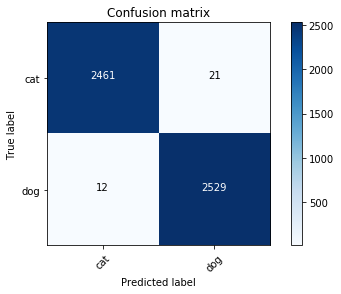

In [32]:
plot_confusion_matrix(cm, data.classes)

In [33]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


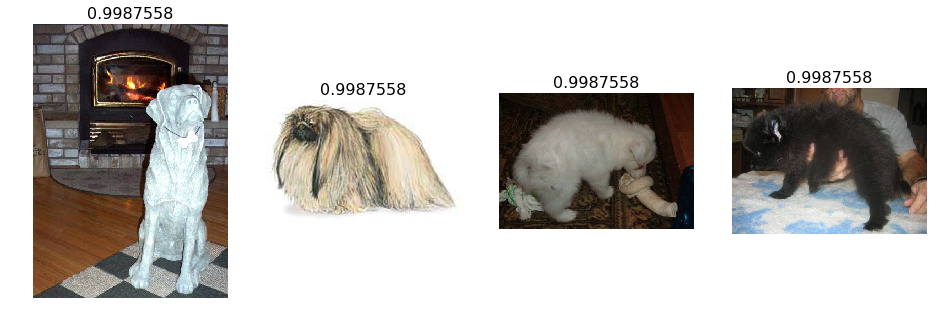

In [34]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


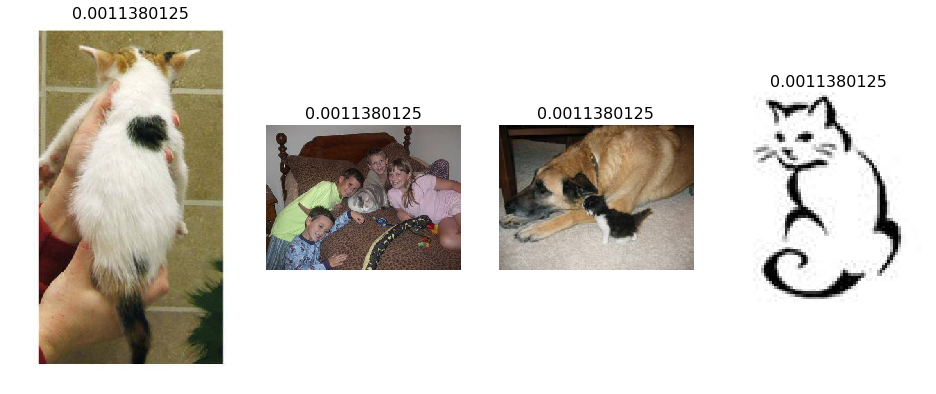

In [35]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")